In [1]:
pip install keras-tuner tensorflow numpy matplotlib seaborn scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.0 MB/s eta 0:00:00


# Imports

In [2]:
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shutil
import csv
from numpy import log, mean, std, floor, exp, expand_dims
from scipy.linalg import sqrtm
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.applications.inception_v3 import InceptionV3, preprocess_input


# 1. Setup and Loggers

In [3]:
# Dictionaries to hold epoch counts per trial
epoch_counts_per_trial_RandomSearch = {}
epoch_counts_per_trial_BO = {}
epoch_counts_per_trial_Hyperband = {}

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Callback to log Generator and Discriminator losses
class GANDashboard(tf.keras.callbacks.Callback):
    def __init__(self):
        super(GANDashboard, self).__init__()
        self.gen_losses = []
        self.disc_losses = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        gen_loss = logs.get('g_loss')
        disc_loss = logs.get('d_loss')
        if gen_loss is not None and disc_loss is not None:
            self.gen_losses.append(min(max(gen_loss, 0), 5))
            self.disc_losses.append(min(max(disc_loss, 0), 5))

# Callback to log epoch counts for Hyperband trials
class EpochsLogger(tf.keras.callbacks.Callback):
    def __init__(self, trial_epoch_dict):
        super(EpochsLogger, self).__init__()
        self.epoch_count = 0
        self.trial_epoch_dict = trial_epoch_dict

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_count += 1

    def on_trial_end(self, trial, logs=None):
        self.trial_epoch_dict[trial.trial_id] = self.epoch_count
        print(f"Trial {trial.trial_id} completed with {self.epoch_count} epochs.")
        self.epoch_count = 0 # Reset for the next trial

Mounted at /content/drive


# 2. GAN and HyperModel definitions

In [20]:
# The GAN model structure
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn, **kwargs):
        super(GAN, self).compile(**kwargs)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0)
        labels += 0.05 * tf.random.uniform(labels.shape)

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {"g_loss": self.gen_loss_tracker.result(), "d_loss": self.disc_loss_tracker.result()}

# Keras Tuner HyperModel definition
class HyperGAN(kt.HyperModel):
    def __init__(self, class_model, gan_dashboard_cb=None, epochs_logger=None):
        super(HyperGAN, self).__init__()
        self.class_model = class_model
        self.gan_dashboard_cb = gan_dashboard_cb
        self.epochs_logger = epochs_logger

    def make_discriminator_model(self, hp_drop_rate):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(hp_drop_rate))
        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(hp_drop_rate))
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        return model

    def make_generator_model(self, latent_dim, batch_norm, activation_function):
        model = tf.keras.Sequential()
        model.add(layers.Dense(7*7*256, use_bias=False, input_shape=[latent_dim]))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(activation_function)
        model.add(layers.Reshape((7, 7, 256)))
        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(activation_function)
        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(activation_function)
        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
        return model

    def build(self, hp):
        hp_drop_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.9)
        batch_norm = hp.Boolean('batch_normalization')
        activation_choice = hp.Choice('activation_function', ['relu', 'leaky_relu', 'sigmoid', 'softmax'])
        hp_latent_dim = 100 # Fixed latent dimension

        activation_dict = {
            'leaky_relu': layers.LeakyReLU(),
            'relu': layers.ReLU(),
            'sigmoid': layers.Activation('sigmoid'),
            'softmax': layers.Activation('softmax'),
        }
        activation_function = activation_dict[activation_choice]

        discriminator = self.make_discriminator_model(hp_drop_rate)
        generator = self.make_generator_model(hp_latent_dim, batch_norm, activation_function)
        model_gan = GAN(discriminator, generator, hp_latent_dim)
        d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        model_gan.compile(d_optimizer, g_optimizer, binary_crossentropy, run_eagerly=True)
        return model_gan

    def calculate_score(self, model, images, n_split=10, eps=1e-16):
        # Process images
        processed = np.expand_dims(images, -1).astype("float32")
        yhat = self.class_model.predict(processed)
        scores = []
        n_part = floor(images.shape[0] / n_split)
        for i in range(n_split):
            ix_start, ix_end = int(i * n_part), int((i + 1) * n_part)
            p_yx = yhat[ix_start:ix_end]
            p_y = expand_dims(p_yx.mean(axis=0), 0)
            kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
            sum_kl_d = kl_d.sum(axis=1)
            avg_kl_d = mean(sum_kl_d)
            is_score = exp(avg_kl_d)
            scores.append(is_score)
        is_avg, is_std = mean(scores), std(scores)
        return is_avg

    def fit(self, hp, model, x, **kwargs):
        callbacks = kwargs.get('callbacks', [])
        if self.gan_dashboard_cb:
            callbacks.append(self.gan_dashboard_cb)
        if self.epochs_logger:
            callbacks.append(self.epochs_logger)
        kwargs['callbacks'] = callbacks

        model.fit(x, **kwargs)

        random_latent_vectors = tf.random.normal(shape=(500, model.latent_dim))
        generated_images = model.generator.predict(random_latent_vectors)
        mean_score = self.calculate_score(self.class_model, generated_images)
        return mean_score

# 3. Prepare Data and Classifier

In [17]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Build and train the MNIST classifier used for Inception Score
num_classes = 10
input_shape = (28, 28, 1)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

classifier_model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])
classifier_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
classifier_model.fit(x_train, y_train_cat, batch_size=128, epochs=15, validation_split=0.1)


Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7683 - loss: 0.7533 - val_accuracy: 0.9772 - val_loss: 0.0824
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9643 - loss: 0.1156 - val_accuracy: 0.9845 - val_loss: 0.0557
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9741 - loss: 0.0870 - val_accuracy: 0.9877 - val_loss: 0.0468
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9782 - loss: 0.0676 - val_accuracy: 0.9883 - val_loss: 0.0395
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9807 - loss: 0.0612 - val_accuracy: 0.9893 - val_loss: 0.0391
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9814 - loss: 0.0554 - val_accuracy: 0.9892 - val_loss: 0.0377
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9850 - loss: 0.0490 - val_accuracy: 0.9912 - val_loss: 0.0337
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9858 - loss: 0.0456 - val_accuracy: 0.

# 4. Initialize Tuners and Callbacks

In [21]:
# Instantiate loss dashboards for each technique
gan_dashboard_cb_RandomSearch = GANDashboard()
gan_dashboard_cb_BO = GANDashboard()
gan_dashboard_cb_Hyperband = GANDashboard()

# Instantiate epoch loggers for each technique
epochs_logger_RandomSearch = EpochsLogger(epoch_counts_per_trial_RandomSearch)
epochs_logger_BO = EpochsLogger(epoch_counts_per_trial_BO)
epochs_logger_Hyperband = EpochsLogger(epoch_counts_per_trial_Hyperband)

# 5. Run Hyperparameter Searches

In [22]:
# RandomSearch
print("--- Starting Random Search ---")
start_time = time.time()
tuner_RandomSearch = kt.RandomSearch(
    hypermodel=HyperGAN(classifier_model, gan_dashboard_cb_RandomSearch, epochs_logger_RandomSearch),
    objective=kt.Objective("score", direction="max"),
    max_trials=20,
    overwrite=True,
    directory="my_dir",
    project_name="custom_eval_RandomSearch",
)
tuner_RandomSearch.search(x_train, epochs=20)
end_time = time.time()
print(f"Random Search Time: {end_time - start_time:.2f} seconds")
tuner_RandomSearch.results_summary()

# Bayesian Optimization
print("\n--- Starting Bayesian Optimization ---")
start_time = time.time()
tuner_BO = kt.BayesianOptimization(
    hypermodel=HyperGAN(classifier_model, gan_dashboard_cb_BO, epochs_logger_BO),
    objective=kt.Objective("score", direction="max"),
    max_trials=20,
    overwrite=True,
    directory="my_dir",
    project_name="custom_eval_bo",
)
tuner_BO.search(x_train, epochs=20)
end_time = time.time()
print(f"Bayesian Optimization Time: {end_time - start_time:.2f} seconds")
tuner_BO.results_summary()

# Hyperband
print("\n--- Starting Hyperband ---")
start_time = time.time()
tuner_Hyperband = kt.Hyperband(
    hypermodel=HyperGAN(classifier_model, gan_dashboard_cb_Hyperband, epochs_logger_Hyperband),
    objective=kt.Objective("score", direction="max"),
    max_epochs=40,
    factor=3,
    overwrite=True,
    directory="my_dir",
    project_name="custom_eval_hyperband",
)
tuner_Hyperband.search(x_train, epochs=20)
end_time = time.time()
print(f"Hyperband Time: {end_time - start_time:.2f} seconds")
tuner_Hyperband.results_summary()

--- Starting Random Search ---

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.022634          |0.022634          |dropout_rate
False             |False             |batch_normalization
sigmoid           |sigmoid           |activation_function

Epoch 1/20
 404/1875 ━━━━━━━━━━━━━━━━━━━━ 3:23 139ms/step - d_loss: 0.3456 - g_loss: 1.9863

KeyboardInterrupt: 

# 6. Save Results and Visulise

In [ ]:
# Save tuner results to Google Drive
def save_tuner_results(project_name, tuner_type):
    source_path = f"/content/my_dir/{project_name}"
    destination_path = f"/content/drive/MyDrive/CombinedTuner/{tuner_type}/{project_name}"
    if os.path.exists(destination_path):
        shutil.rmtree(destination_path)
    shutil.copytree(source_path, destination_path)
    print(f"Saved {tuner_type} results to Drive.")

save_tuner_results("custom_eval_RandomSearch", "RandomSearch")
save_tuner_results("custom_eval_bo", "BO")
save_tuner_results("custom_eval_hyperband", "Hyperband")

# Function to plot and show images
def plot_multiple_images(images, search_type, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    plt.savefig(f"/content/drive/MyDrive/CombinedTuner/{search_type}/generated_images.png")
    plt.show()

def tuner_show_images(tuner, search_type):
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.save(f'/content/drive/MyDrive/CombinedTuner/{search_type}/{search_type}_model.h5')
    random_latent_vectors = tf.random.normal(shape=(20, best_model.latent_dim))
    generated_images = best_model.generator.predict(random_latent_vectors)
    plot_multiple_images(generated_images, search_type, 5)

print("\n--- Generating and Saving Images ---")
tuner_show_images(tuner_RandomSearch, 'RandomSearch')
tuner_show_images(tuner_BO, 'BO')
tuner_show_images(tuner_Hyperband, 'Hyperband')


# Function to create confusion matrices
def create_confusion_matrix(tuner, tuner_name, x_test_data):
    print(f"\n--- Creating Confusion Matrix for {tuner_name} ---")
    best_model = tuner.get_best_models(num_models=1)[0]
    num_images_to_generate = 1500

    # Generate fake images
    random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, best_model.latent_dim))
    generated_images = best_model.generator(random_latent_vectors, training=False)

    # Get real images
    real_images = x_test_data[:num_images_to_generate]

    # Get predictions
    real_predictions = best_model.discriminator.predict(real_images)
    fake_predictions = best_model.discriminator.predict(generated_images)

    # Binarize predictions and create labels
    true_labels = np.concatenate([np.ones(len(real_predictions)), np.zeros(len(fake_predictions))])
    predictions_binarized = np.concatenate([(real_predictions > 0).astype(int), (fake_predictions > 0).astype(int)])

    # Generate and plot matrix
    conf_matrix = confusion_matrix(true_labels, predictions_binarized, labels=[1, 0])
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix for {tuner_name} Discriminator')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"/content/drive/MyDrive/CombinedTuner/{tuner_name}/confusion_matrix.png")
    plt.show()

create_confusion_matrix(tuner_RandomSearch, 'RandomSearch', x_test)
create_confusion_matrix(tuner_BO, 'BO', x_test)
create_confusion_matrix(tuner_Hyperband, 'Hyperband', x_test)

# Save loss data
def save_losses(dashboard, name, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    gen_loss_path = os.path.join(save_dir, f'{name}_gen_losses.csv')
    disc_loss_path = os.path.join(save_dir, f'{name}_disc_losses.csv')
    with open(gen_loss_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'GenLoss'])
        for i, loss in enumerate(dashboard.gen_losses):
            writer.writerow([i, loss])
    with open(disc_loss_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'DiscLoss'])
        for i, loss in enumerate(dashboard.disc_losses):
            writer.writerow([i, loss])
    print(f'Losses saved for {name} to {save_dir}')

dashboards_data = [
    (gan_dashboard_cb_RandomSearch, 'RandomSearch'),
    (gan_dashboard_cb_BO, 'BO'),
    (gan_dashboard_cb_Hyperband, 'Hyperband')
]

for dashboard, name in dashboards_data:
    save_losses(dashboard, name, f"/content/drive/MyDrive/CombinedTuner/{name}/losses")

print("\n--- All experiments and visualizations complete. ---")


# BOX PLOT GENERATION CODE

--- Inception Score Medians ---
Random Search: 5.716
Bayesian Optimisation: 5.816
Hyperband: 5.889


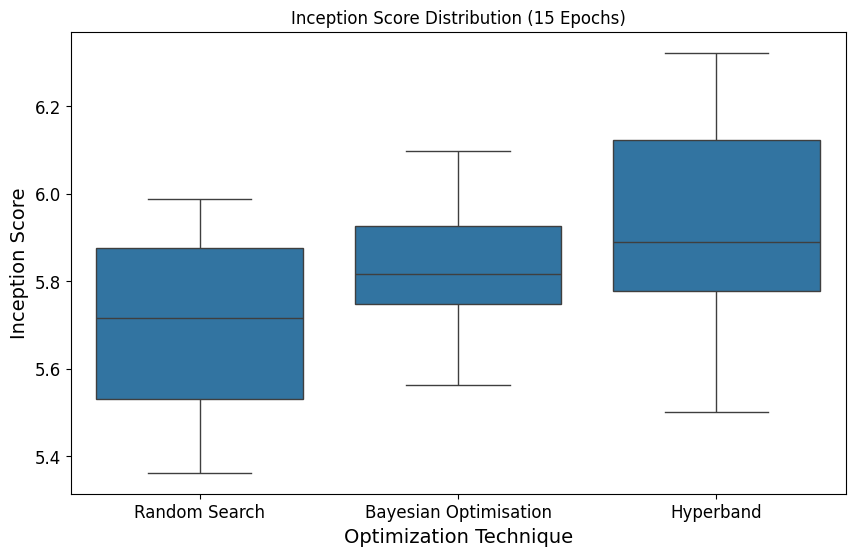


--- FID Score Medians ---
Random Search: 0.287
Bayesian Optimisation: 0.194
Hyperband: 0.182


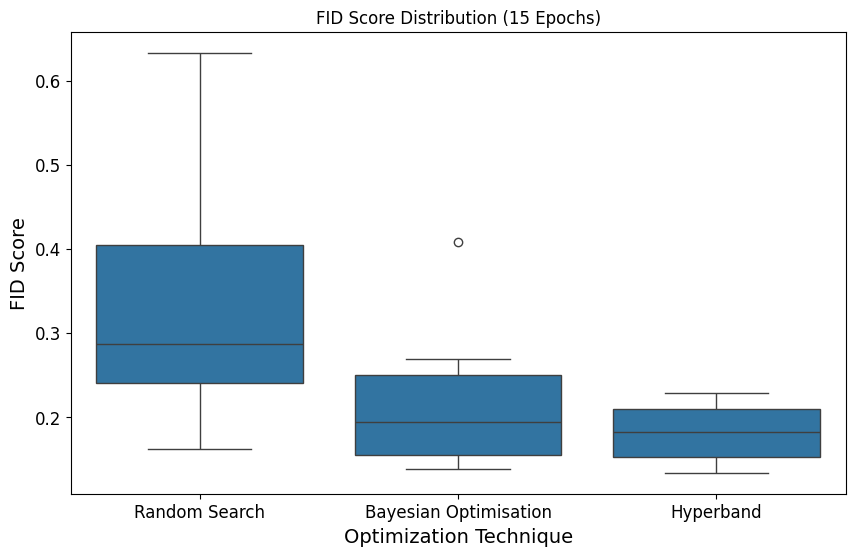

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics

# --- Inception Score Distribution Plot (15 epochs) ---
is_data = {
    'Random Search': [5.812, 5.988, 5.619, 5.558, 5.885, 5.491, 5.523, 5.930, 5.851, 5.362],
    'Bayesian Optimisation': [5.639, 5.811, 5.741, 5.767, 5.822, 5.563, 5.852, 5.950, 6.098, 5.971],
    'Hyperband': [6.151, 5.922, 6.098, 6.132, 5.856, 5.774, 5.787, 5.614, 5.501, 6.323]
}

# Calculate and print medians
print("--- Inception Score Medians ---")
print(f"Random Search: {statistics.median(is_data['Random Search']):.3f}")
print(f"Bayesian Optimisation: {statistics.median(is_data['Bayesian Optimisation']):.3f}")
print(f"Hyperband: {statistics.median(is_data['Hyperband']):.3f}")

# Create DataFrame and plot
df_is = pd.DataFrame(is_data)
df_is_melted = df_is.melt(var_name='Optimization Technique', value_name='Inception Score')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Optimization Technique', y='Inception Score', data=df_is_melted)
plt.title('Inception Score Distribution (15 Epochs)')
plt.xlabel('Optimization Technique', fontsize=14)
plt.ylabel('Inception Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("/content/drive/MyDrive/CombinedTuner/IS_distribution_15_epochs.png")
plt.show()


# --- FID Score Distribution Plot (15 epochs) ---
fid_data = {
    'Random Search': [0.257459, 0.161511, 0.378658, 0.316154, 0.257141, 0.485299, 0.175229, 0.633282, 0.234047, 0.412567],
    'Bayesian Optimisation': [0.408415, 0.269401, 0.253668, 0.151680, 0.188681, 0.238455, 0.141044, 0.138179, 0.164583, 0.199363],
    'Hyperband': [0.185769, 0.178746, 0.147703, 0.202596, 0.212325, 0.145504, 0.218537, 0.133597, 0.168472, 0.228887]
}

# Calculate and print medians
print("\n--- FID Score Medians ---")
print(f"Random Search: {statistics.median(fid_data['Random Search']):.3f}")
print(f"Bayesian Optimisation: {statistics.median(fid_data['Bayesian Optimisation']):.3f}")
print(f"Hyperband: {statistics.median(fid_data['Hyperband']):.3f}")

# Create DataFrame and plot
df_fid = pd.DataFrame(fid_data)
df_fid_melted = df_fid.melt(var_name='Optimization Technique', value_name='FID Score')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Optimization Technique', y='FID Score', data=df_fid_melted)
plt.title('FID Score Distribution (15 Epochs)')
plt.xlabel('Optimization Technique', fontsize=14)
plt.ylabel('FID Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("/content/drive/MyDrive/CombinedTuner/FID_distribution_15_epochs.png")
plt.show()